In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

from keras.layers import Embedding, LSTM, Dense, Dropout, Activation
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def preprocessing(df):
    '''
    Drop unnecessary columns.
    Rename columns.
    Convert target labels into numerical.
    '''
    df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
    df = df.rename(columns={'v1': 'label', 'v2': 'sms'})
    # Convert label into numerical
    df['label_numerical'] = df.label.map({'ham': 0, 'spam': 1})
    return df

In [3]:
def split_train_test(df):
    '''
    Split training and test.
    '''
    data = {}
    data['X_train'], data['X_test'], data['y_train'], data['y_test'] = train_test_split(
        df['sms'], df['label_numerical'], test_size=0.2, random_state=100)
    return data

In [4]:
def tokenize(data, num_top_word, max_text_length):
    '''
    Tokenize input string of characters.
    '''
    tokenizer = Tokenizer(num_words=num_top_word)
    tokenizer.fit_on_texts(data['X_train'])
    train_sequences = tokenizer.texts_to_sequences(data['X_train'])
    data['X_train_seq'] = pad_sequences(train_sequences,
                                        maxlen=max_text_length,
                                        padding='post',
                                        truncating='post')
    train_sequences = tokenizer.texts_to_sequences(data['X_test'])
    data['X_test_seq'] = pad_sequences(train_sequences,
                                       maxlen=max_text_length,
                                       padding='post',
                                       truncating='post')
    print('\nTraining label count:')
    print(np.unique(data['y_train'], return_counts=True))

In [5]:
def smote(data):
    '''
    (Modeling technique) SMOTE.
    Balance training/test set samples.
    '''
    sm = SMOTE(random_state=100)
    data['X_train_seq'], data['y_train'] = sm.fit_sample(data['X_train_seq'], data['y_train'])
    print('\nAfter SMOTE, training label count:')
    print(np.unique(data['y_train'], return_counts=True))

In [6]:
def train_rnn(data, num_top_word, embedding_vector_length, max_text_length):
    '''
    Train a RNN classification model.
    '''
    model = Sequential()
    model.add(Embedding(input_dim=num_top_word,
                        output_dim=embedding_vector_length,
                        input_length=max_text_length))
    model.add(LSTM(24))
    # model.add(Dense(64, activation='relu', input_dim=embedding_vector_length))
    # model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    model.fit(x=data['X_train_seq'], y=data['y_train'], epochs=10, validation_split=0.2)
    return model

In [7]:
def compute_performance(models):
    '''
    Compute model performance.
    '''
    result = {}
    for name, model in models.items():
        result[name] = {}
        result[name]['predict_prob_train'] = model.predict_proba(data['X_train_seq']).flatten()
        result[name]['predict_prob_test'] = model.predict_proba(data['X_test_seq']).flatten()
        result[name]['auc_train'] = roc_auc_score(data['y_train'], result[name]['predict_prob_train'])
        result[name]['auc_test'] = roc_auc_score(data['y_test'], result[name]['predict_prob_test'])
        result[name]['fpr'], result[name]['tpr'], result[name]['roc_threshold'] = \
            roc_curve(data['y_test'], result[name]['predict_prob_test'])
        result[name]['precision'], result[name]['recall'], result[name]['pr_threshold'] = \
            precision_recall_curve(data['y_test'], result[name]['predict_prob_test'])
    return result

In [8]:
def print_ml_performance(models, result):
    '''
    Print model performance
    '''
    for name in models.keys():
        print('\nModel performance:')
        print('%s, Training set - auc score: %.4f' % (name, result[name]['auc_train']))
        print('%s, Test set - auc score: %.4f' % (name, result[name]['auc_test']))

In [9]:
def plot_roc(result):
    plt.figure(0).clf()
    for name in result.keys():
        fpr = result[name]['fpr']
        tpr = result[name]['tpr']
        plt.plot(fpr, tpr, label=(name + ' auc=' + '%.2f' % (result[name]['auc_test'])))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

In [10]:
def plot_pr(result):
    plt.figure(1).clf()
    for name in result.keys():
        precision = result[name]['precision']
        recall = result[name]['recall']
        plt.plot(recall, precision, label=(name))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc='lower right')
    plt.show()

In [11]:
def understand_misclassification(name, result, data, threshold):
    '''
    Understand misclassified sms text by the model.
    '''
    print('\ne.g. for %s' % (name))
    prediction = np.where(result[name]['predict_prob_test'] > threshold, 1, 0)
    print('\n Confusion Matrix:')
    print(confusion_matrix(data['y_test'], prediction))  # Confusion matrix
    print(classification_report(data['y_test'], prediction, digits=4))
    # Understand mis-classifications
    print('\nFalse positives (ham incorrectly classified as spam):')
    print(data['X_test'][prediction > data['y_test']])  # False positives
    print('\nFalse negatives (spam incorrectly classified as ham):')
    print(data['X_test'][prediction < data['y_test']])  # False negatives

In [12]:
########## Run the code ##########
# Import data
# https://www.kaggle.com/uciml/sms-spam-collection-dataset
df = pd.read_csv('spam.csv', encoding='latin-1')
print('\nFirst few lines of data:')
print(df.head())  # print first few lines


First few lines of data:
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


In [13]:
df = preprocessing(df)
print('\nFirst few lines of data after pre-processing:')
print(df.head())  # Print first few lines
# print(df.groupby('label').describe()) # Count observations


First few lines of data after pre-processing:
  label                                                sms  label_numerical
0   ham  Go until jurong point, crazy.. Available only ...                0
1   ham                      Ok lar... Joking wif u oni...                0
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...                1
3   ham  U dun say so early hor... U c already then say...                0
4   ham  Nah I don't think he goes to usf, he lives aro...                0


In [14]:
# Training / Test split
data = split_train_test(df)

In [15]:
# Tokenize input
num_top_word = 1000
max_text_length = 20
tokenize(data, num_top_word, max_text_length)


Training label count:
(array([0, 1]), array([3855,  602]))


In [16]:
# SMOTE
# smote(data)

In [24]:
# Recursive Neural Network
embedding_vector_length = 32
models = {}
models['RNN'] = train_rnn(data, num_top_word, embedding_vector_length, max_text_length)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 32)            32000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 24)                5472      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25        
Total params: 37,497
Trainable params: 37,497
Non-trainable params: 0
_________________________________________________________________
None
Train on 3565 samples, validate on 892 samples
Epoch 1/10
3565/3565 [==============================] - 5s 1ms/step - loss: 0.3037 - acc: 0.8996 - val_loss: 0.1192 - val_acc: 0.9742
Epoch 2/10
3565/3565 [==============================] - 3s 905us/step - loss: 0.0840 - acc: 0.9840 - val_loss: 0.0806 - val_acc: 0.9787
Epoch 3/10
3565/3565 [==============================] - 3s 908us/step - loss: 0.

In [25]:
# Final evaluation of the model
result = compute_performance(models)

In [26]:
print_ml_performance(models, result)


Model performance:
RNN, Training set - auc score: 0.9957
RNN, Test set - auc score: 0.9943


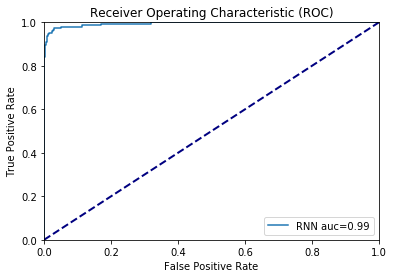

In [27]:
plot_roc(result)

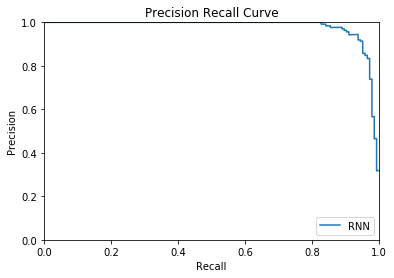

In [28]:
plot_pr(result)

In [29]:
# Understand misclassification
name = 'RNN'
threshold = 0.5
understand_misclassification(name, result, data, threshold)


e.g. for RNN

 Confusion Matrix:
[[961   9]
 [  9 136]]
             precision    recall  f1-score   support

          0     0.9907    0.9907    0.9907       970
          1     0.9379    0.9379    0.9379       145

avg / total     0.9839    0.9839    0.9839      1115


False positives (ham incorrectly classified as spam):
5142    Now that you have started dont stop. Just pray...
2339    Cheers for the message Zogtorius. IåÕve been s...
4727    I (Career Tel) have added u as a contact on IN...
1219    True. It is passable. And if you get a high sc...
1383    Please reserve ticket on saturday eve from che...
1937    The fact that you're cleaning shows you know w...
1289    Hey...Great deal...Farm tour 9am to 5pm $95/pa...
2092    Oh, my love, it's soooo good to hear from you....
3105    I had been hoping i would not have to send you...
Name: sms, dtype: object

False negatives (spam incorrectly classified as ham):
2429    Guess who am I?This is the first time I create...
5540    ASKED

In [30]:
# Save model
# models['RNN'].save('rnn.h5')